## Epifluorescence analysis for gfap:jrGECO recordings - Figure 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.io as sio
import nrrd
import napari
import cv2

Load reference brain (see reference brain uploaded to the github)

In [2]:

filename = r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/epi_analysis_folder/gfap_recordings/reference_brain_GFAP.nrrd'

# Read the data back from file
reference, header = nrrd.read(filename)
print(reference.shape)
print(header)

(351, 506)
OrderedDict([('type', 'uint8'), ('encoding', 'raw'), ('endian', 'big'), ('dimension', 2), ('sizes', array([351, 506])), ('space dimension', 2), ('space directions', array([[1., 0., 0.],
       [0., 1., 0.]])), ('space units', ['pixel', 'pixel'])])


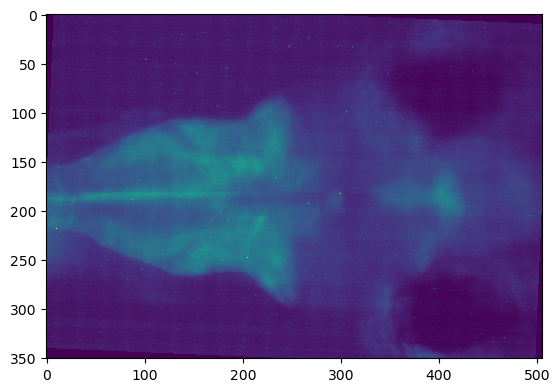

In [3]:
plt.imshow(reference, interpolation='nearest')
plt.show()

# Example video to check out how it looks (no registration)

In [4]:
filename = r'/Users/marc/Downloads/clonidine_50uM_plus_ket_treatment_2fish_4000_100ug.nrrd'

# Read the data back from file
video, header = nrrd.read(filename)
print(video.shape)
print(header)

(1238, 1046, 2696)
OrderedDict([('type', 'uint8'), ('encoding', 'raw'), ('endian', 'big'), ('dimension', 3), ('sizes', array([1238, 1046, 2696])), ('space dimension', 3), ('space directions', array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])), ('space units', ['pixel', 'pixel', 'pixel'])])


Check for nans

In [5]:
np.argwhere(np.isnan(video[:,:,1]))

array([], shape=(0, 2), dtype=int64)

In [6]:
a = np.swapaxes(video,0,2)
viewer = napari.view_image(a, name='Ket', colormap='magma')

This example video has two fish, so let's select one to test the registration

In [88]:
filename = r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Notebooks_paper_for_github/example_notebook.nrrd'

# Read the data back from file
video, header = nrrd.read(filename)
print(video.shape)
print(header)




(556, 700, 2696)
OrderedDict([('type', 'uint8'), ('dimension', 3), ('sizes', array([ 556,  700, 2696])), ('encoding', 'gzip')])


In [30]:
plt.imshow(np.max(video[:,:,:], axis = 2))
plt.show()

# Register the video

Here is the function for the registration

In [183]:
def align_to_reference(test, reference):


    # Read the images to be aligned
    im1 =  reference
    im2 =  test

    # Convert images to grayscale
    im1_gray = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im2_gray = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    #warp_mode = cv2.MOTION_AFFINE
    
    
    #warp_mode = cv2.MOTION_HOMOGRAPHY


    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 1000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps =1e-2;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
    # Use warpAffine for Translation, Euclidean 
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    return im2_aligned


In [184]:
cut_video = video[:,:,:]

In [185]:
#sometimes if the image is too bright we might need to adjust the contrast to make it brighter (i.e normalize?)
shape_video= cut_video.shape
shape_reference = reference.shape
#create numpy array
registered = np.zeros((shape_reference[0],shape_reference[1],shape_video[2]))
'''
for frame in range(1):
    registered_frame = align_to_reference(cut_video[:,:,frame],reference)
    registered[:,:,frame] = registered_frame
'''
for frame in range(shape_video[2]):
    registered_frame = align_to_reference(cut_video[:,:,frame],reference)
    registered[:,:,frame] = registered_frame


In [187]:
#checkout registered video

import napari

a = np.swapaxes(registered,0,2)
viewer = napari.view_image(a, name='Registered', colormap='magma')

Reference and registered side by side

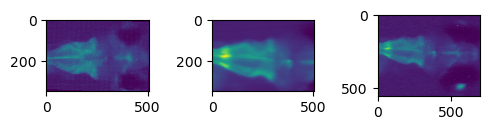

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].imshow(reference, interpolation='nearest')
axes[1].imshow(np.mean(registered[:,:,:],axis = 2), interpolation='nearest')
axes[2].imshow(np.mean(cut_video[:,:,:],axis = 2), interpolation='nearest')
fig.tight_layout()

In [189]:

nrrd.write('/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Notebooks_paper_for_github/registered_output.nrrd', registered)

# Calculate total brain fluorescence and z-score

In [211]:
#astrocytes
registered,_ =  nrrd.read(r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Notebooks_paper_for_github/registered_output.nrrd')
fish_n = '1'
compound = 'ket'
#define all the masks
results_f1 = {}
region_names = ['caudal_hindbrain_GFAP','cerebellum_gfap','habenulla_gfap','rostral_hindbrain_GFAP','midline_gfap','caudal_midline_gfap','hindbrain_gfap']
for name in region_names:
    raw_hindbrain = []
    dF_hindbrain = []
    filename = r'/Users/marc/Library/CloudStorage/GoogleDrive-mduqueramirez@g.harvard.edu/My Drive/Papers/duque_et_al_ketamine/epi_analysis_folder/'+name+'.nrrd'
    mask, header = nrrd.read(filename)
    for frame in range(registered.shape[2]):
        sub = registered[:,:,frame]
        raw_hindbrain.append((np.mean(sub[np.where(mask >0)])))
    #normalize
    raw_hindbrain = np.asarray(raw_hindbrain)
    dF_hindbrain = (raw_hindbrain-np.mean(raw_hindbrain[1:200]))/np.std(raw_hindbrain[1:200])
    #dF_hindbrain = dF_hindbrain/np.max(dF_hindbrain)
    dF_hindbrain  = dF_hindbrain[0:2000]
    d = {name: dF_hindbrain
        #'fish_number':fish_n,
        #'compound':compound
        }
    results_f1.update(d)


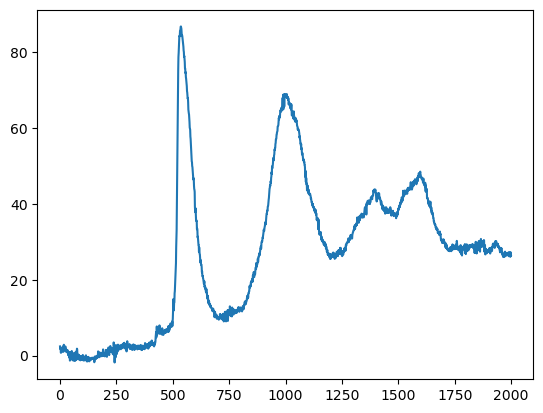

In [194]:
d = (results_f1['midline_gfap'])
plt.plot(d)
#plt.savefig('control_recording.pdf', dpi =600 )

In [196]:
np.average(results_f1['midline_gfap'][200:2000])

29.79034325499124

In [205]:
def add_stim_to_plot(ax):
    ax.axvspan(start_stim, end_stim, alpha=shade_alpha,
               color='gray')
    ax.axvline(start_stim, alpha=lines_alpha, color='gray', ls='--')
    ax.axvline(end_stim, alpha=lines_alpha, color='gray', ls='--')

In [208]:
from matplotlib.lines import Line2D
import seaborn as sns
shade_alpha      = 0.2
lines_alpha      = 0.8
pal = sns.color_palette('husl', 9)
%config InlineBackend.figure_format = 'svg'
start_stim = 200
end_stim = 2000
time = np.arange(0,2000)
fig, ax = plt.subplots(1, 1, figsize=[10, 5], sharey='row')
ax.plot(time, x, c=pal[0])
ax.set_ylim(-10, 100)
sns.set_style("white")
add_stim_to_plot(ax)
ax.set_ylabel('Z-score')
ax.set_xlabel('Time (s)')
sns.despine(fig=fig, right=True, top=True)
plt.tight_layout(rect=[0, 0, 0.9, 1])
#plt.savefig('hindbrain_t1.pdf')  

# Heatmap for astrocytes

In [215]:
import seaborn as sns
import pandas as pd
heat = pd.DataFrame.from_dict(results_f1)


sns.set(rc={'figure.figsize':(5,5)})

sns.set(font_scale=1.4)
#sns.diverging_palette(270, 10, as_cmap=True)
ax = sns.heatmap(heat,cmap= 'inferno',yticklabels=False,vmax = 100, vmin =-10)
ax.invert_yaxis()
#plt.savefig('heatmap_full_wave.pdf', dpi =600 )

